In [73]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score, mean_absolute_error
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_w_imp.columns if x.startswith("WIAT") or x.startswith("WISC")] # All WISC and WIAT columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC

# Separate test set for all output columns

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [74]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth': np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    return (best_estimator, best_score)

In [75]:
def find_best_estimator_for_output(output_col):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, output_col)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [76]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

In [77]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("best-estimators-cog-scores-item-lvl.csv")

    dump(best_estimators, 'best-estimators-cog-scores-item-lvl.joblib', compress=1)

In [78]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-cog-scores-item-lvl.joblib')

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using versio

In [91]:
metric_names = ['r2', 'MAE', 'Target Score Range (for MAE interpretation)']   

def get_min_max_for_mae_interpretation(output_col):
    return (item_lvl_w_imp[output_col].min(), item_lvl_w_imp[output_col].max())

def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    target_score_range = str(get_min_max_for_mae_interpretation(output_col))
    metrics += [r2, mae, target_score_range]
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.xlim(get_min_max_for_mae_interpretation(output_col)[0], get_min_max_for_mae_interpretation(output_col)[1])
        plt.ylim(get_min_max_for_mae_interpretation(output_col)[0], get_min_max_for_mae_interpretation(output_col)[1])
        plt.show()
        
    return metrics

WIAT,WIAT_Num_Stnd


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.142029,0.550399
1,0.055323,0.562467
2,0.059084,0.555525
3,0.132360,0.557538
4,0.117240,0.552577


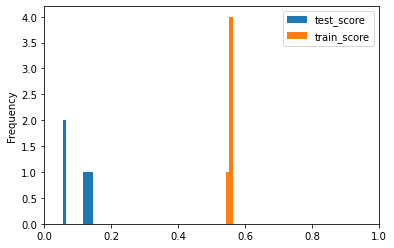

WIAT,WIAT_Word_Stnd


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.142029,0.550399
1,0.055323,0.562467
2,0.059084,0.555525
3,0.132360,0.557538
4,0.117240,0.552577


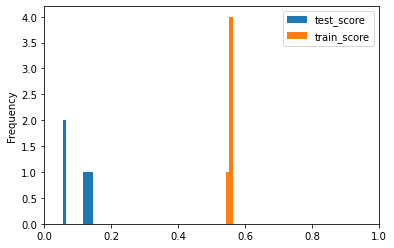

WISC,WISC_Coding_Scaled


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.142029,0.550399
1,0.055323,0.562467
2,0.059084,0.555525
3,0.132360,0.557538
4,0.117240,0.552577


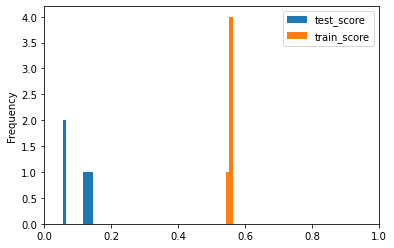

WISC,WISC_FSIQ


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.142029,0.550399
1,0.055323,0.562467
2,0.059084,0.555525
3,0.132360,0.557538
4,0.117240,0.552577


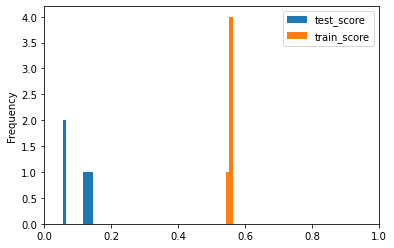

WISC,WISC_SS_Scaled


/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,test_score,train_score
0,0.142029,0.550399
1,0.055323,0.562467
2,0.059084,0.555525
3,0.132360,0.557538
4,0.117240,0.552577


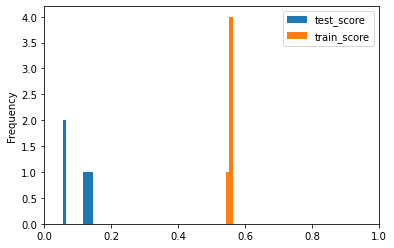

,Output,Mean R2,Std R2,Mean MAE,Std MAE,Target Score Range (for MAE interpretation)
0,"WIAT,WIAT_Num_Stnd",0.170518,0.039395,11.968456,0.337955,"(46.0, 160.0)"
1,"WIAT,WIAT_Word_Stnd",0.277980,0.061836,11.274345,0.437441,"(40.0, 153.0)"
2,"WISC,WISC_Coding_Scaled",0.137987,0.027354,2.310493,0.075951,"(1.0, 19.0)"
3,"WISC,WISC_FSIQ",0.398866,0.030406,10.210505,0.237116,"(47.0, 147.0)"
4,"WISC,WISC_SS_Scaled",0.122103,0.026573,2.277581,0.100377,"(1.0, 19.0)"


In [92]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50)
    plt.xlim(0, 1)
    plt.show()

results_val_set = []
for output in output_cols:
    print(output)
    estimator = best_estimators[output]
    r2_cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, scoring="r2")
    r2_scores = [np.mean(r2_cv_results["test_score"]), np.std(r2_cv_results["test_score"])]
    mae_cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, scoring="neg_mean_absolute_error")
    mae_scores = [np.mean(-mae_cv_results["test_score"]), np.std(-mae_cv_results["test_score"])]
    results_val_set.append([
        output, 
        *r2_scores,
        *mae_scores,
        get_min_max_for_mae_interpretation(output)])
    
    plot_test_vs_train_scores(cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2", "Mean MAE", "Std MAE", "Target Score Range (for MAE interpretation)"])
display(restults_val_set_df)

In [93]:
display(restults_val_set_df[["Output", "Mean R2", "Mean MAE", "Target Score Range (for MAE interpretation)"]])

,Output,Mean R2,Mean MAE,Target Score Range (for MAE interpretation)
0,"WIAT,WIAT_Num_Stnd",0.170518,11.968456,"(46.0, 160.0)"
1,"WIAT,WIAT_Word_Stnd",0.277980,11.274345,"(40.0, 153.0)"
2,"WISC,WISC_Coding_Scaled",0.137987,2.310493,"(1.0, 19.0)"
3,"WISC,WISC_FSIQ",0.398866,10.210505,"(47.0, 147.0)"
4,"WISC,WISC_SS_Scaled",0.122103,2.277581,"(1.0, 19.0)"


In [94]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in output_cols:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

ValueError: X has 850 features, but RandomForestRegressor is expecting 46 features as input.

### Feature importance

In [95]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-cog-scores-item-lvl.joblib')
    except Exception as e: print(e)

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using versio

In [96]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

In [97]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in output_cols:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [98]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-cog-scores-item-lvl.joblib', compress=1)

WIAT,WIAT_Num_Stnd


,r2
1,0.097093
2,0.118478
3,0.135942
4,0.171360
5,0.193017
...,...
96,0.237478
97,0.238330
98,0.238556
99,0.239195


Max score:  0.24361043348107425  at  46  features


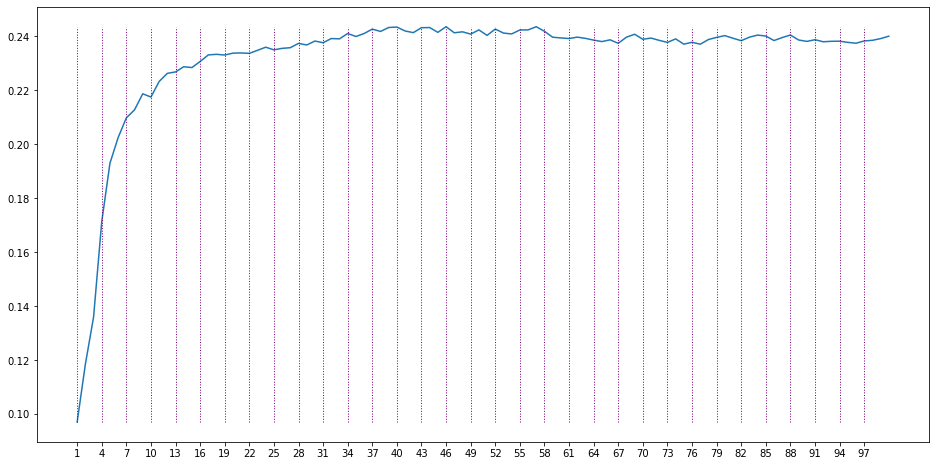

Optimal number of features:  12


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'ASSQ,ASSQ_02',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_61',
 'CBCL,CBCL_83',
 'ICU_P,ICU_P_20',
 'APQ_P,APQ_P_31',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'APQ_SR,APQ_SR_07A_WAS_MISSING')

Score using all features: 
WIAT,WIAT_Num_Stnd
r2:  0.20480116547289784


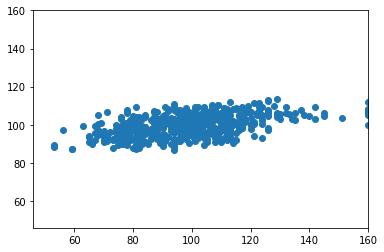

R2:  0.20480116547289784
Performance on test set using optimal number of columns: 
WIAT,WIAT_Num_Stnd
r2:  0.23084129186912972


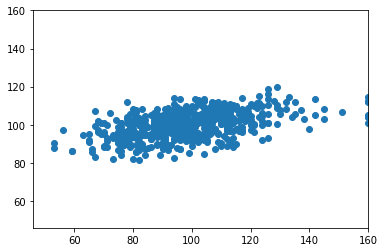

R2:  0.23084129186912972
Performance on test set using number of columns with maximum score
WIAT,WIAT_Num_Stnd
r2:  0.24371371260365549


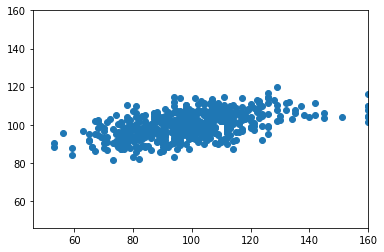

R2:  0.24371371260365549
WIAT,WIAT_Word_Stnd


,r2
1,0.126396
2,0.152093
3,0.173225
4,0.187148
5,0.200570
...,...
96,0.363553
97,0.363808
98,0.364050
99,0.364272


Max score:  0.36449283525090176  at  100  features


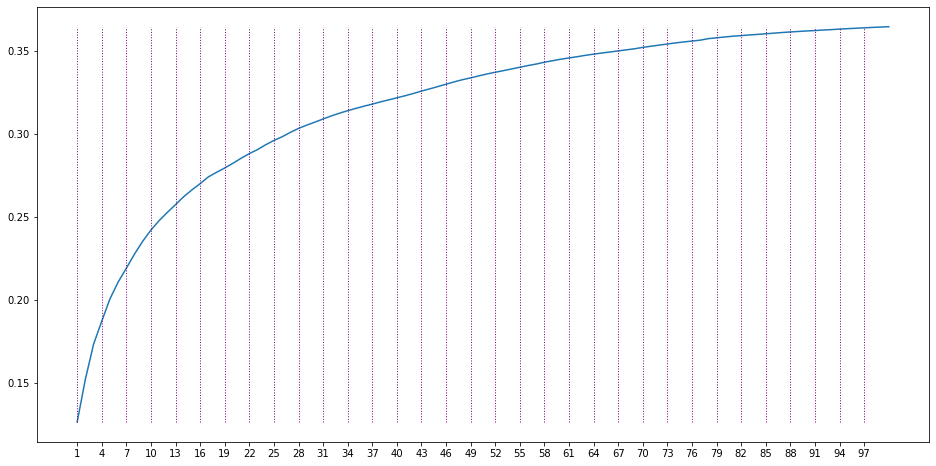

Optimal number of features:  27


('SympChck,CSC_36C',
 'SympChck,CSC_46P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_14',
 'ASSQ,ASSQ_05',
 'SDQ,SDQ_20',
 'SDQ,SDQ_27',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_06',
 'SRS,SRS_09',
 'SRS,SRS_14',
 'CBCL,CBCL_04',
 'CBCL,CBCL_17',
 'CBCL,CBCL_58',
 'CBCL,CBCL_61',
 'CBCL,CBCL_79',
 'APQ_P,APQ_P_34',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'MFQ_P,MFQ_P_01',
 'APQ_SR,APQ_SR_16',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'RBS,RBS_09',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_15A_WAS_MISSING')

Score using all features: 
WIAT,WIAT_Word_Stnd
r2:  0.28359706211737123


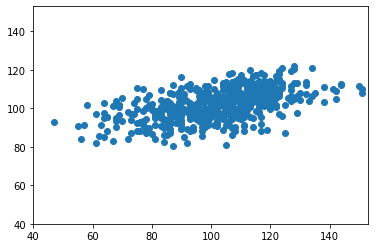

R2:  0.28359706211737123
Performance on test set using optimal number of columns: 
WIAT,WIAT_Word_Stnd
r2:  0.2757452880293654


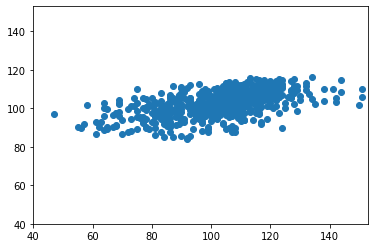

R2:  0.2757452880293654
Performance on test set using number of columns with maximum score
WIAT,WIAT_Word_Stnd
r2:  0.3269615770873442


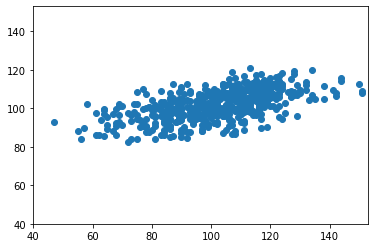

R2:  0.3269615770873442
WISC,WISC_Coding_Scaled


,r2
1,0.056349
2,0.082354
3,0.106561
4,0.130794
5,0.140609
...,...
96,0.188421
97,0.188421
98,0.188421
99,0.188421


Max score:  0.18842179327074915  at  64  features


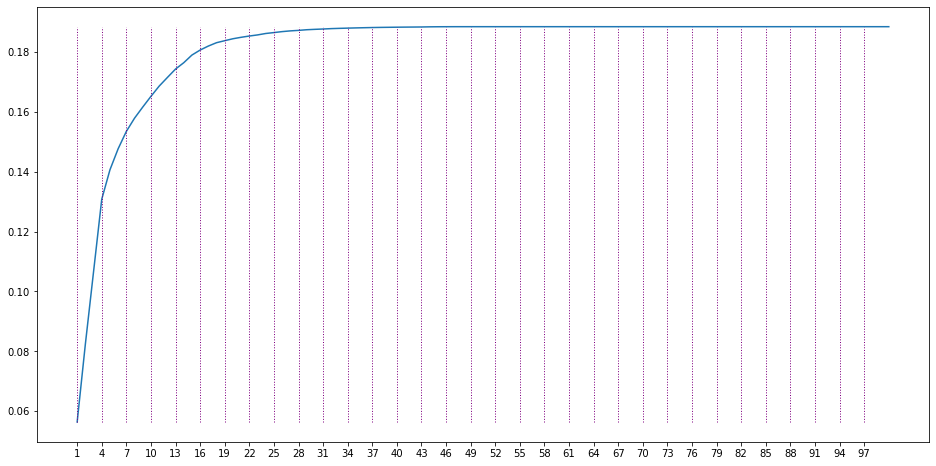

Optimal number of features:  17


('Basic_Demos,Age',
 'Basic_Demos,Sex',
 'SympChck,CSC_06P',
 'ASSQ,ASSQ_01',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_21',
 'SRS,SRS_49',
 'CBCL,CBCL_01',
 'CBCL,CBCL_18',
 'CBCL,CBCL_62',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_06',
 'APQ_P,APQ_P_35',
 'APQ_P,APQ_P_40',
 'APQ_SR,APQ_SR_39',
 'PSI,PSI_18')

Score using all features: 
WISC,WISC_Coding_Scaled
r2:  0.16680260044171757


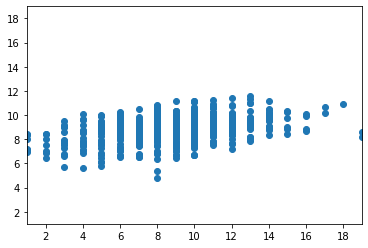

R2:  0.16680260044171757
Performance on test set using optimal number of columns: 
WISC,WISC_Coding_Scaled
r2:  0.17135286109194603


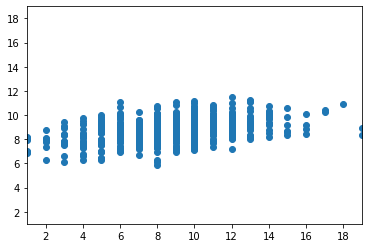

R2:  0.17135286109194603
Performance on test set using number of columns with maximum score
WISC,WISC_Coding_Scaled
r2:  0.17771465284706633


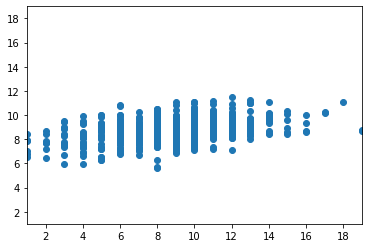

R2:  0.17771465284706633
WISC,WISC_FSIQ


,r2
1,0.192420
2,0.228383
3,0.254970
4,0.279349
5,0.299521
...,...
96,0.473444
97,0.473494
98,0.473546
99,0.473598


Max score:  0.4736383310965497  at  100  features


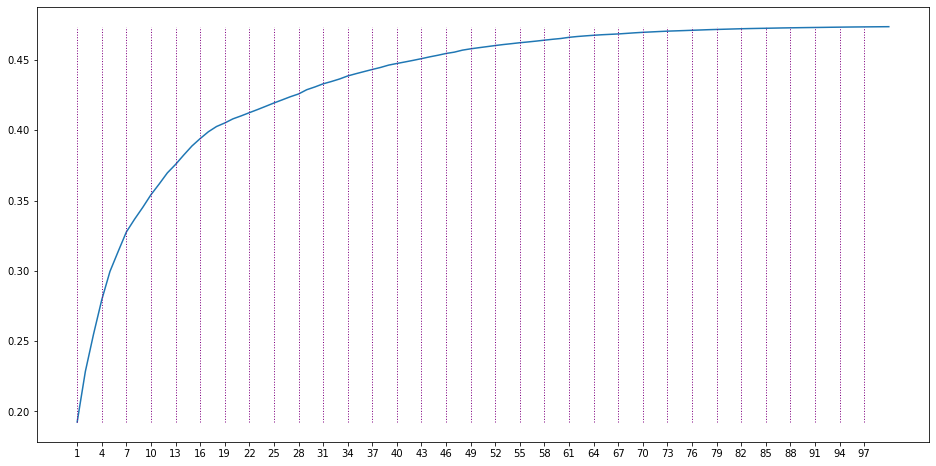

Optimal number of features:  18


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'Barratt,financialsupport',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'APQ_P,APQ_P_18',
 'APQ_P,APQ_P_31',
 'APQ_P,APQ_P_37',
 'ESWAN,MDD_5',
 'APQ_SR,APQ_SR_05',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_02',
 'PSI,PSI_08',
 'PSI,PSI_18',
 'RBS,RBS_36')

Score using all features: 
WISC,WISC_FSIQ
r2:  0.45236040752713447


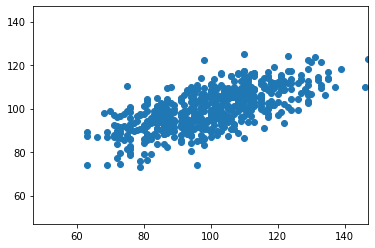

R2:  0.45236040752713447
Performance on test set using optimal number of columns: 
WISC,WISC_FSIQ
r2:  0.40690548536299587


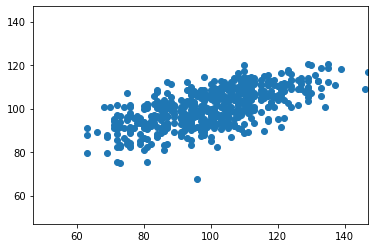

R2:  0.40690548536299587
Performance on test set using number of columns with maximum score
WISC,WISC_FSIQ
r2:  0.44220732509783367


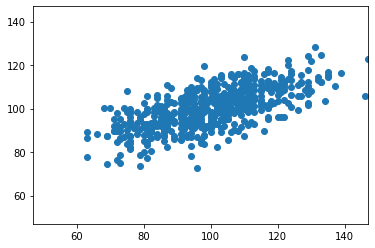

R2:  0.44220732509783367
WISC,WISC_SS_Scaled


,r2
1,0.053645
2,0.067750
3,0.079969
4,0.091022
5,0.106628
...,...
96,0.149738
97,0.152605
98,0.154892
99,0.155849


Max score:  0.15584931744894162  at  99  features


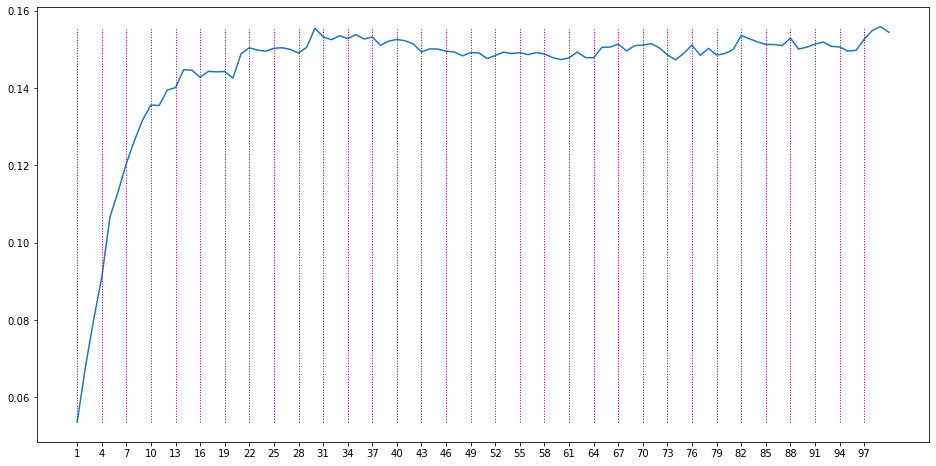

Optimal number of features:  14


('SympChck,CSC_18P',
 'SympChck,CSC_43C',
 'SCQ,SCQ_03',
 'ASSQ,ASSQ_04',
 'ASSQ,ASSQ_11',
 'CBCL,CBCL_03',
 'CBCL,CBCL_32',
 'ICU_P,ICU_P_02',
 'ICU_P,ICU_P_09',
 'APQ_P,APQ_P_31',
 'ESWAN,Panic_B02',
 'PSI,PSI_05',
 'PSI,PSI_18',
 'RBS,RBS_40')

Score using all features: 
WISC,WISC_SS_Scaled
r2:  0.10874253824383218


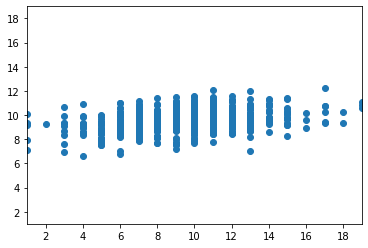

R2:  0.10874253824383218
Performance on test set using optimal number of columns: 
WISC,WISC_SS_Scaled
r2:  0.09146304940211103


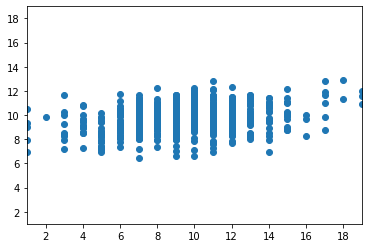

R2:  0.09146304940211103
Performance on test set using number of columns with maximum score
WISC,WISC_SS_Scaled
r2:  0.09233844279179115


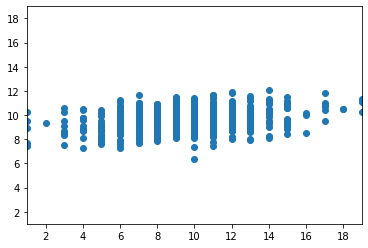

R2:  0.09233844279179115


In [99]:
# Print sfs results
for output in output_cols:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimator, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])